# Convolutional Neural Networks in Pytorch

A more complete example of implementing a convolutional network in Pytorch is [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In [1]:
# Modified from https://github.com/vinhkhuc/PyTorch-Mini-Tutorials

import numpy as np

import torch
from torch.autograd import Variable
print(torch.__version__)

import time

import gzip
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

1.12.1


## **Useful link to understand CNN shape and dimension**
https://poloclub.github.io/cnn-explainer/

Let's define our `pytorch` version with a contructor that is called like
```python
    nnet = ConvNet((1, 28, 28), n_hiddens_per_conv_layer=[4, 2], n_hiddens_per_fc_layer=[10], len(np.unique(T)),
                   patch_size_per_conv_layer=[5, 4], stride_per_conv_layer=[2, 2])                   
```

You will see in train() that we are training subsets (batches) of our data in a loop.

Why do you suppose we are doing this?

In [2]:
%%writefile convnet.py

import numpy as np
import torch
        
class ConvNet(torch.nn.Module):
    
    def __init__(self, input_shape, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs, 
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):
        
        super().__init__()
        
        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers or
            len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')
        
        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu
        
        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = input_shape[0]
        input_hw = input_shape[1]  # = input_shape[2]
        self.conv_layers = torch.nn.ModuleList()
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append( torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride) )
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh # new channel number becomes equal to channel size of previous hidden layer

        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in  # n_hiddens_per_fc_layer[0]
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append( torch.nn.Linear(n_in, nh) )
            n_in = nh

        output_layer = torch.nn.Linear(n_in, n_outputs)
        self.fc_layers.append(output_layer)
        
        output_layer.weight.data[:] = 0.0
        output_layer.bias.data[:] = 0.0

        self.loss_trace = []
        self.accuracy_trace = []
        
        self.to(self.device)


    def _forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append( self.activation_function(conv_layer(Ys[-1])) )

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                flattend_inputs = Ys[-1].reshape(n_samples, -1)
                Ys.append( self.activation_function(fc_layer(flattend_inputs)) )
            else:
                Ys.append( self.activation_function(fc_layer(Ys[-1])) )

        if len(self.fc_layers) == 1:  # no fully connected hidden layers
            flattend_inputs = Ys[-1].reshape(n_samples, -1)
            Ys.append(self.fc_layers[-1](flattend_inputs))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))
        return Ys


    def _forward(self, X):
        Ys = self._forward_all_outputs(X)
        return Ys[-1]
    

    def to_torch(self, M, torch_type=torch.FloatTensor):
        if not isinstance(M, torch.Tensor):
            return torch.from_numpy(M).type(torch_type).to(self.device)
        return M
        
    def percent_correct(self, Y_classes, T):
        if isinstance(T, torch.Tensor):
            T = T.cpu().numpy()
        return (Y_classes == T).mean() * 100
    
    def train(self, Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='sgd', verbose=True,
              Xval=None, Tval=None):
        
        # Assuming Ttrain includes all possible class labels
        self.classes = np.unique(Ttrain)

        # Set data matrices to torch.tensors if not already.

        Xtrain = self.to_torch(Xtrain)
        Ttrain = self.to_torch(Ttrain, torch.LongTensor)
        Xval = self.to_torch(Xval) if Xval is not None else None
        Tval = self.to_torch(Tval, torch.LongTensor) if Tval is not None else None
        
        Xtrain.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        loss_f = torch.nn.CrossEntropyLoss(reduction='mean')
        
        for epoch in range(n_epochs):

            if batch_size == -1:
                num_batches = 1
            else:
                num_batches = Xtrain.shape[0] // batch_size

            loss_sum = 0
            class_train_sum = 0
            
            for k in range(num_batches):
                
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = Xtrain[start:end, ...]
                T_batch = Ttrain[start:end, ...]
                
                Y = self._forward(X_batch)
                
                loss = loss_f(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

                with torch.no_grad():
                    class_train_sum += self.percent_correct(self.use(X_batch)[0], T_batch)
                    
            self.loss_trace.append((loss_sum.item() / num_batches))
            percent_correct_train = class_train_sum / num_batches
            if Xval is not None:
                with torch.no_grad():
                    percent_correct_val = self.percent_correct(self.use(Xval)[0], Tval)
                self.accuracy_trace.append([percent_correct_train, percent_correct_val])
            else:
                self.accuracy_trace.append(percent_correct_train)
                
            if verbose and (epoch + 1) % (n_epochs // 10) == 0:
                print(method, 'Epoch', epoch + 1, 'Loss', self.loss_trace[-1])

        return self


    def _softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1,1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y


    def use(self, X):
        # Set input matrix to torch.tensors if not already.
        with torch.no_grad():
            X = self.to_torch(X)
            Y = self._forward(X)
            probs = self._softmax(Y).cpu().numpy()
            classes = self.classes[np.argmax(probs, axis=1)]
            return classes, probs

    def get_loss_trace(self):
        return self.loss_trace

    def get_accuracy_trace(self):
        return self.accuracy_trace



Overwriting convnet.py


In [3]:
import convnet
%load_ext autoreload
%autoreload 2

In [4]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Would you like to run on the GPU? (y or n): y
Running on cuda:0


In [5]:
!nvidia-smi

Thu Nov  3 20:18:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P8     6W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1] 
Xval = valid_set[0]
Tval = valid_set[1]
Xtest = test_set[0]
Ttest = test_set[1] 

In [7]:
Xtrain.shape

(50000, 784)

In [8]:
# Convolutional nets in pytorch require reshaping the input matrices
Xtrain_cnn = Xtrain.reshape(-1, 1, 28, 28)
Xval_cnn = Xval.reshape(-1, 1, 28, 28)
Xtest_cnn = Xtest.reshape(-1, 1, 28, 28)

In [9]:
Xtrain_cnn.shape

(50000, 1, 28, 28)

In [24]:
cnnet = convnet.ConvNet(Xtrain_cnn.shape[1:], [10, 20], [5], 10,
                patch_size_per_conv_layer=[5, 7], stride_per_conv_layer=[2, 2],
                device=device)

n_epochs = 100
batch_size = 1000
learning_rate = 0.001
cnnet.train(Xtrain_cnn, Ttrain, batch_size, n_epochs, learning_rate, method='adam',
            Xval=Xval_cnn, Tval=Tval)

adam Epoch 10 Loss 1.1370624542236327
adam Epoch 20 Loss 0.5759486389160157
adam Epoch 30 Loss 0.34469406127929686
adam Epoch 40 Loss 0.18785072326660157
adam Epoch 50 Loss 0.12790266036987305
adam Epoch 60 Loss 0.09584269523620606
adam Epoch 70 Loss 0.07256397724151611
adam Epoch 80 Loss 0.05885711669921875
adam Epoch 90 Loss 0.05960137844085693
adam Epoch 100 Loss 0.04099784374237061


ConvNet(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(2, 2))
    (1): Conv2d(10, 20, kernel_size=(7, 7), stride=(2, 2))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=180, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=10, bias=True)
  )
)

In [25]:
def percent_correct(Y_classes, T):
    return np.mean(Y_classes == T) * 100

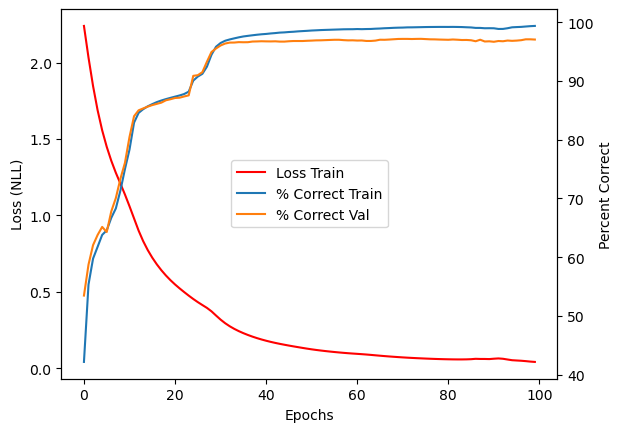

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
loss_trace = cnnet.get_loss_trace()
plot1 = ax.plot(loss_trace, 'r-')
ax.set_ylabel('Loss (NLL)')
ax.set_xlabel('Epochs')

acc_train = percent_correct(cnnet.use(Xtrain_cnn)[0], Ttrain)
acc_val = percent_correct(cnnet.use(Xval_cnn)[0], Tval)
acc_test = percent_correct(cnnet.use(Xtest_cnn)[0], Ttest)
accuracies = cnnet.get_accuracy_trace()
xs = range(0, len(loss_trace), len(loss_trace) // len(accuracies))

ax2 = ax.twinx()
plot2 = ax2.plot(xs, accuracies)
ax2.set_ylabel('Percent Correct')

plots = plot1 + plot2
if len(plot2) == 1:
  ax.legend(plots, ('Loss Train', '% Correct Train'), loc='center')
else:
  ax.legend(plots, ('Loss Train', '% Correct Train', '% Correct Val'), loc='center')

In [27]:
# returns the moduels of the trained cnn
list(cnnet.children())

[ModuleList(
   (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(2, 2))
   (1): Conv2d(10, 20, kernel_size=(7, 7), stride=(2, 2))
 ),
 ModuleList(
   (0): Linear(in_features=180, out_features=5, bias=True)
   (1): Linear(in_features=5, out_features=10, bias=True)
 )]

In [28]:
# indexing to extract a certain convolutional layer
list(cnnet.children())[0][0]

Conv2d(1, 10, kernel_size=(5, 5), stride=(2, 2))

In [29]:
# extracting weight
list(cnnet.children())[0][0].weight.data   # 10 weights for 10 units in convolutional hidden layer

tensor([[[[-3.7824e-01, -6.1005e-01, -3.5171e-01, -1.6224e-01, -2.0647e-01],
          [-3.0628e-01, -6.3488e-01, -1.8293e-01, -1.1101e-01, -2.1906e-01],
          [-3.6832e-01, -1.1741e-01,  4.4589e-02,  4.0607e-01,  3.5460e-01],
          [-4.5618e-01, -2.6460e-01,  3.5205e-01,  5.5138e-01,  3.9985e-01],
          [-5.3019e-01, -2.3356e-02,  2.8697e-01,  3.0413e-01,  4.1820e-01]]],


        [[[-7.8191e-02,  9.2497e-02,  4.2433e-01,  1.5872e-01,  4.5149e-01],
          [-5.3197e-01,  7.5604e-03,  4.7604e-01,  4.9674e-01,  1.7536e-01],
          [-1.0406e+00, -5.0568e-01, -2.1804e-01, -2.1840e-01, -5.4205e-01],
          [-6.0953e-01, -1.0901e+00, -1.3994e+00, -1.1007e+00, -9.8063e-01],
          [ 1.0653e-01,  1.0613e-01,  1.5764e-01, -1.6151e-02, -2.3566e-01]]],


        [[[ 1.8812e-01,  2.0675e-01,  3.4247e-01,  3.7564e-01,  2.3610e-01],
          [-1.1186e-01,  2.8835e-01,  3.9085e-01,  2.0149e-01,  3.1598e-01],
          [-2.1218e-01, -9.3652e-03,  1.2725e-02,  1.9140e-02,  3.13

In [30]:
x = Xtest_cnn[20:21]
x = torch.from_numpy(x).float().to(device)
Ys = cnnet._forward_all_outputs(x)

In [31]:
x.shape

torch.Size([1, 1, 28, 28])

In [32]:
x.squeeze().shape

torch.Size([28, 28])

In [33]:
Ttest[20]

9

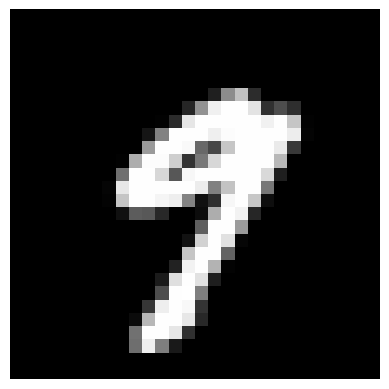

In [34]:
plt.imshow(x.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off');

In [35]:
layer1weights = list(cnnet.children())[0][0].weight.data
layer1weights.shape

torch.Size([10, 1, 5, 5])

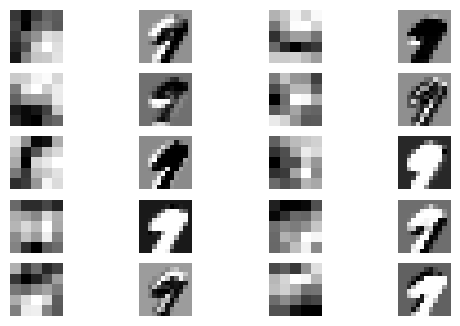

In [36]:
ploti = 0
for i in range(10):
    ploti += 1
    plt.subplot(6, 4, ploti)
    plt.imshow(layer1weights[i].squeeze().cpu(), cmap='gray')
    plt.axis('off')
    ploti += 1
    plt.subplot(6, 4, ploti)
    plt.imshow(Ys[1][0, i, :, :].detach().squeeze().cpu(), cmap='gray')
    plt.axis('off')

In [37]:
cnnet

ConvNet(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(2, 2))
    (1): Conv2d(10, 20, kernel_size=(7, 7), stride=(2, 2))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=180, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=10, bias=True)
  )
)

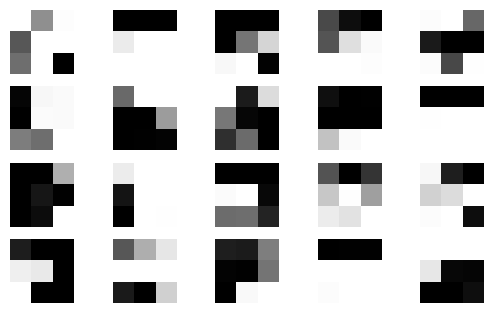

In [38]:
# layer2weights = list(cnnet.children())[1][0].weight.data

ploti = 0
for i in range(20):
    ploti += 1
    plt.subplot(5, 5, ploti)
    plt.imshow(Ys[2][0, i, :, :].detach().squeeze().cpu(), cmap='gray')
    plt.axis('off')

In [61]:
Xtest_cnn.shape

(10000, 1, 28, 28)

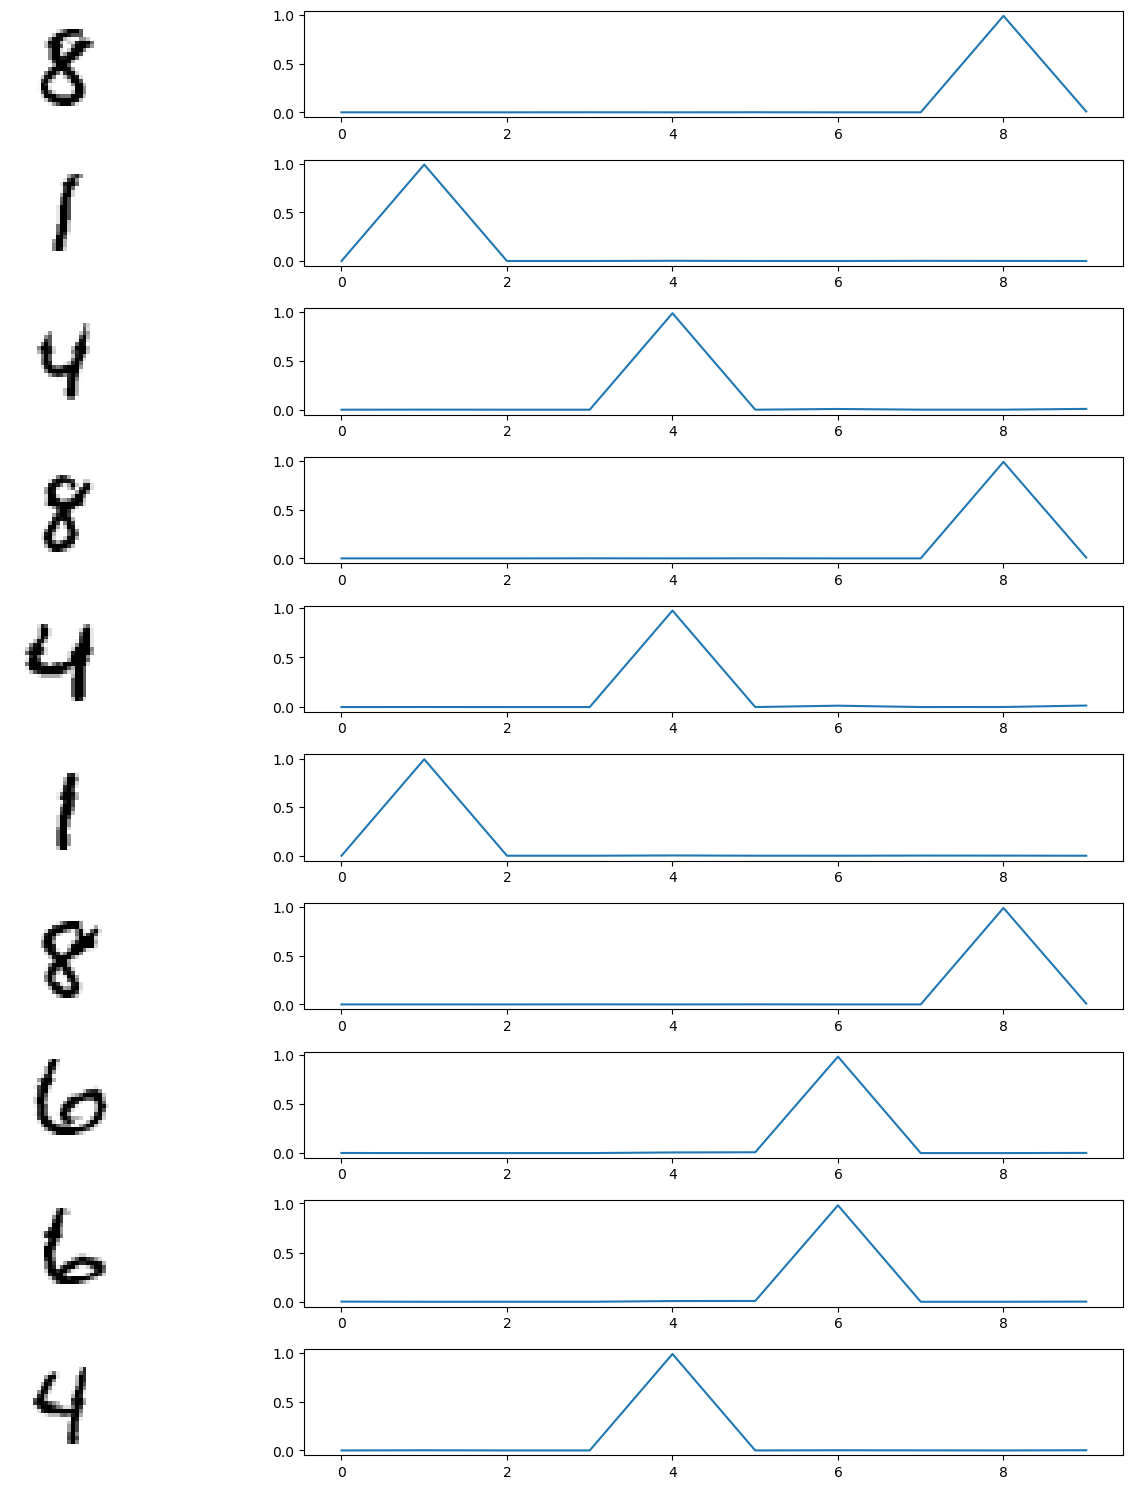

In [62]:
first = np.random.randint(9000)

x = Xtest_cnn[first:first + 10]
Classes, Probs = cnnet.use(x)

plt.figure(figsize=(15, 15))
ploti = 0
for i in range(10):
    ploti += 1
    plt.subplot(10, 2, ploti)
    plt.imshow(-x[i, 0, :, :], cmap='gray')
    plt.axis('off')
    ploti += 1
    plt.subplot(10, 2, ploti)
    # Try calculating this my self
    Yprobs = Probs[i, :]
    plt.plot(Yprobs)
plt.tight_layout()